# COMP90084 Workshop Week 7
In this week's workshop, we'll program the algorithms we encountered during the lectures last week.

In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, QuantumRegister, ClassicalRegister
import qiskit as qk
from qiskit.circuit import Gate
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import matplotlib.pyplot as plt
from qiskit.quantum_info import partial_trace, DensityMatrix, Statevector
%matplotlib inline
# shots simulation
backend_sim = Aer.get_backend('qasm_simulator')
# statevector
backend_sv = Aer.get_backend('statevector_simulator')


### Q1.1

Q1.1.a - Print quantum circuit
Q1.1.a - Show ouput meets specification


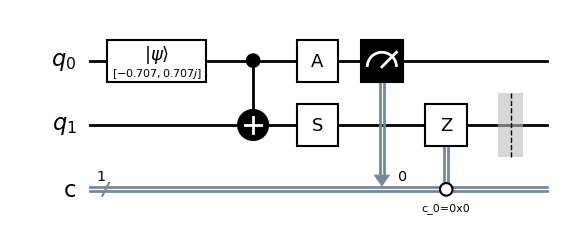

State observed q1:
 [[0.5       +0.j         0.35355339-0.35355339j]
 [0.35355339+0.35355339j 0.5       +0.j        ]]

State expected q1:
 [[0.5       +0.j         0.35355339+0.35355339j]
 [0.35355339-0.35355339j 0.5       +0.j        ]]


In [42]:
from math import sqrt
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info.states import Statevector
import math

print("Q1.1.a - Print quantum circuit")
print("Q1.1.a - Show ouput meets specification")

alpha = complex(0.24506488, 0.9633)
beta = complex(0.0046248, 0.10943)




def Q1(a, b):
    qc = QuantumCircuit(2, 1)
    qc.initialize([a,b], 0)
    qc.cx(0,1)
    qc.s(1)
    sqrt_2_half = math.sqrt(2)/2
    recp_sqrt_2 = 1/math.sqrt(2)
    # qc.barrier()
    cx = Operator([
        [recp_sqrt_2, -recp_sqrt_2*complex(sqrt_2_half, sqrt_2_half)],
        [recp_sqrt_2, recp_sqrt_2*complex(sqrt_2_half, sqrt_2_half)],
    ])
    qc.unitary(cx, 0, label='A')
    qc.measure(0,0)
    qc.z(1).c_if(0, 0)
    qc.snapshot(label="Bob_State", qubits=[1])
    
    
    
    return qc

# qc = Q1(sqrt(2)/2, sqrt(2)/2)
# a = 0
# b = 1
a=-1/np.sqrt(2)
b=1j/np.sqrt(2)
qc = Q1(a, b)
display(qc.draw('mpl', style = "bw"))

job = backend_sv.run(transpile(qc, backend_sv), shots=1)
result = job.result()


state = partial_trace(result.get_statevector(), [0]) 
print("State observed q1:\n",np.real_if_close(state.data))
print()
sqrt_2_half = math.sqrt(2)/2
T = np.array([
    [1, 0], 
    [0, complex(sqrt_2_half, sqrt_2_half)]])

T_psi = T.dot([a, b])
print("State expected q1:\n",np.real_if_close(DensityMatrix(Statevector(T_psi)).data))


### Q1.2

Q1.2.a

This problem can be solved in 1 query with the Deutsh Jozsa Algorithmn. </br>

Define f as a unitary matrix that can be evaulated in a quantum circuit, that maps $\ket{x}\ket{y} to \ket{x}\ket{y \oplus f(x)}$. </br>
f takes x as input with n qubits. </br>
f oututs to a single qubit y. </br>

We have the initial x values as |0> and the initial y value as |1>.</br>
We apply a Hadamard gate to every qubit in x and y.</br>

Apply the unitary function of f. </br>

Apply hadamard gates to just x qubits are measure the top registers. </br>

If f is constant function then input will remain unchanged and the final hadamard gate will reverse the first and the state of the quibits will still be in the $\ket{0}$ state. </br>
This is because all f(x)=1 or f(x)=0, applies the same global phase to x, which can be factored out in the measurement and not effect the resulting measured state. </br>

If f is a balanced function, half of f(x) = 1 and the other half f(x) = 0, phase kick back adds a negative phase to half of these states, which cannot be factored out effecting the measured state, resulting in us measuring a non $\ket{0}$ value. 

Q1.2.a - Show circuit for f1 f2 f3 f4
Q1.2.a - Show circuit for quantum algorithm
Q1.2.a - Show quantum algorithm works
f1


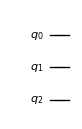

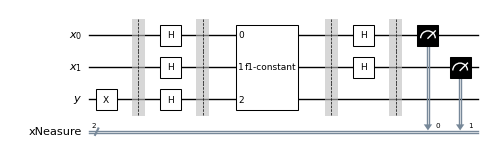

{'00': 10}
constant
-----------------------------------------------------
f2


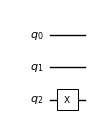

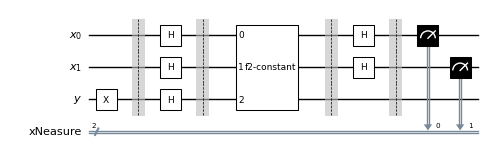

{'00': 10}
constant
-----------------------------------------------------
f3


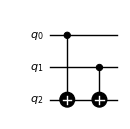

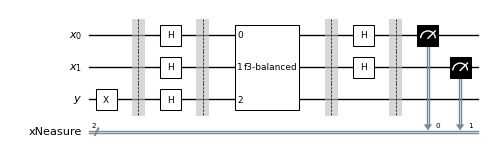

{'11': 10}
balanced
-----------------------------------------------------
f4


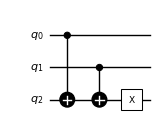

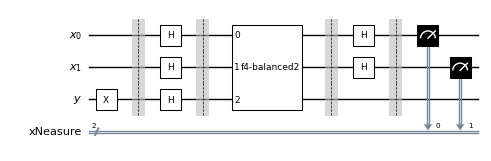

{'11': 10}
balanced


In [41]:
print("Q1.2.a - Show circuit for f1 f2 f3 f4")
print("Q1.2.a - Show circuit for quantum algorithm")
print("Q1.2.a - Show quantum algorithm works")

def f1():
    qc = QuantumCircuit(3, name="f1-constant")
    return qc

def f2():
    qc = QuantumCircuit(3, name="f2-constant")
    qc.x(2)
    return qc


def f3():
    qc = QuantumCircuit(3, name="f3-balanced")
    qc.cx(0, 2)
    qc.cx(1, 2)
    return qc

def f4():
    qc = QuantumCircuit(3, name="f4-balanced2")
    qc.cx(0, 2)
    qc.cx(1, 2)
    qc.x(2)
    return qc

# define the Deutsch-Jozsa function
def deutsch_josza(function=None, num_qubits = 2):
    x = QuantumRegister(num_qubits-1, "x")
    y = QuantumRegister(1, "y")
    cr = ClassicalRegister(num_qubits-1, "xNeasure")

    qc = QuantumCircuit(x, y, cr)
    # X gate on the function output qubit
    qc.x(y)
    qc.barrier()
    # H gate everywhere
    qc.h([*x, *y])
    qc.barrier()
    # append the function
    if function is None:
        f = Gate(name='Uf', num_qubits=num_qubits, params=[])
        qc.append(f, list(range(num_qubits)))
        qc.barrier()
    else:
        f = function.to_instruction()
        qc.append(f, list(range(num_qubits)))
        qc.barrier()
    qc.h(x)
    qc.barrier()
    qc.measure(x, cr)
    return qc

def print_is_balanced_or_constant(Uf, num_qubits):
    display(Uf.draw('mpl',style="bw", scale = 0.5))
    dj_1_qubit = deutsch_josza(Uf, num_qubits)
    display(dj_1_qubit.draw('mpl',style="bw", scale = 0.5))
    job_dj_1_qubit = backend_sim.run(transpile(dj_1_qubit, backend_sim), shots=10)
    result_dj_1_qubit = job_dj_1_qubit.result()
    counts_dj_1_qubit = result_dj_1_qubit.get_counts(dj_1_qubit)
    print(counts_dj_1_qubit)

    max_key = ""
    max_count = 0
    for key in counts_dj_1_qubit:
        count = counts_dj_1_qubit[key]
        if(count > max_count):
            max_count = count
            max_key = key
    
    #if only zeros, then it is constant, else balanaced
    if(max_key.find("1") == -1):
        print("constant")
    else:
        print("balanced")
    
    


print("f1")
print_is_balanced_or_constant(f1(), 3)

print("-----------------------------------------------------")

print("f2")
print_is_balanced_or_constant(f2(), 3)

print("-----------------------------------------------------")

print("f3")
print_is_balanced_or_constant(f3(), 3)

print("-----------------------------------------------------")

print("f4")
print_is_balanced_or_constant(f4(), 3)

Q1.2.2

In [40]:
print("Q1.2.b - Show f1 f2 f3 f4 meet specification")

def f1():
    qc = QuantumCircuit(4, name="f1-constant")
    return qc

def f2():
    qc = QuantumCircuit(4, name="f2-constant")
    qc.x(3)
    return qc


def f3():
    qc = QuantumCircuit(4, name="f3-balanced")
    qc.cx(0, 3)
    qc.cx(1, 3)
    return qc

def f4():
    qc = QuantumCircuit(4, name="f3-balanced")
    qc.cx(0, 3)
    qc.cx(1, 3)
    qc.x(3)
    return qc

def calc_answer(circuit, i, j, k, showExample, showDiagram=False):
    num_qubits = 4

    num_c_bits = 1
    qr = QuantumRegister(num_qubits, "x and y")
    if(showExample):
        cr1 = ClassicalRegister(num_qubits, "zero state")
        cr2 = ClassicalRegister(num_qubits, "initial state")
        cr3 = ClassicalRegister(num_qubits, "output state")

        qc = QuantumCircuit(qr, cr1, cr2, cr3)

        qc.measure(qr, cr1)
        qc.barrier()

    else:
        cr3 = ClassicalRegister(1, "out")
        qc = QuantumCircuit(qr, cr3)

    if(i == 1):
        qc.x(0)
    if(j == 1):
        qc.x(1)
    if(k == 1):
        qc.x(2)

    qc.barrier()
    
    
    if(showExample):
        qc.measure(qr, cr2)
        qc.barrier()

    f = circuit.to_instruction()
    qc.append(f, list(range(num_qubits)))
    qc.barrier()

    if(showExample):
        qc.measure(qr, cr3)
    else:
        qc.measure(3, 0)


    job = backend_sim.run(transpile(qc, backend_sim), shots=1)
    result_dj_1_qubit = job.result()
    counts_dj_1_qubit = result_dj_1_qubit.get_counts(qc)
    if(showDiagram):
        display(qc.draw('mpl',style="bw", scale = 0.5))
    
    max_key = ""
    max_count = 0
    for key in counts_dj_1_qubit:
        count = counts_dj_1_qubit[key]
        if(count > max_count):
            max_count = count
            max_key = key

    max_key = max_key[::-1]

    if(showExample):
        splits = max_key.split(" ")
        return {"zero state: " : splits[0], "initial state: " : splits[1], "output state: " : splits[2]}
    else:
        return max_key

def proof_of_work(circuit):
    
    results = {}

    for i in range(2):
        for j in range(2):
            for k in range(2):
                results[str(i)+str(j)+str(k)] = calc_answer(circuit, i, j, k, False)

    print(circuit.name, end =": ")
    print(results)




proof_of_work(f1())
proof_of_work(f2())
proof_of_work(f3())
proof_of_work(f4())

Q1.2.b - Show f1 f2 f3 f4 meet specification
f1-constant: {'000': '0', '001': '0', '010': '0', '011': '0', '100': '0', '101': '0', '110': '0', '111': '0'}
f2-constant: {'000': '1', '001': '1', '010': '1', '011': '1', '100': '1', '101': '1', '110': '1', '111': '1'}
f3-balanced: {'000': '0', '001': '0', '010': '1', '011': '1', '100': '1', '101': '1', '110': '0', '111': '0'}
f3-balanced: {'000': '1', '001': '1', '010': '0', '011': '0', '100': '0', '101': '0', '110': '1', '111': '1'}


Q1.2.b - Show algorithm working for each function f1 f2 f3 f4
f1


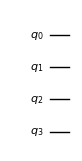

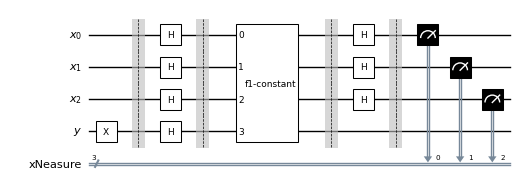

{'000': 10}
constant
-----------------------------------------------------
f2


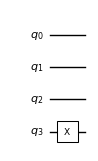

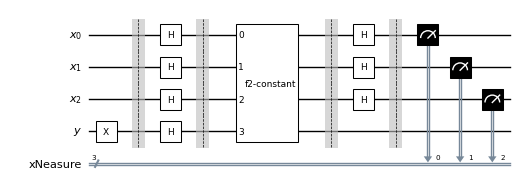

{'000': 10}
constant
-----------------------------------------------------
f3


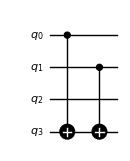

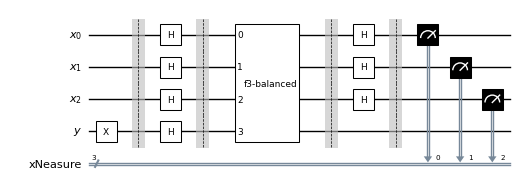

{'011': 10}
balanced
-----------------------------------------------------
f4


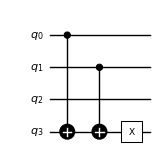

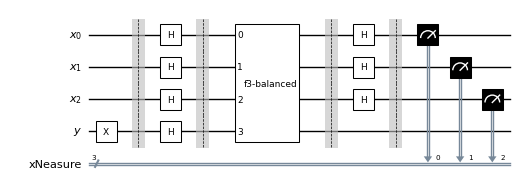

{'011': 10}
balanced


In [39]:
print("Q1.2.b - Show algorithm working for each function f1 f2 f3 f4")

print("f1")
print_is_balanced_or_constant(f1(), 4)

print("-----------------------------------------------------")

print("f2")
print_is_balanced_or_constant(f2(), 4)

print("-----------------------------------------------------")

print("f3")
print_is_balanced_or_constant(f3(), 4)

print("-----------------------------------------------------")

print("f4")
print_is_balanced_or_constant(f4(), 4)

Q1.2.b - Show each step of through circuit for different inputs
f1: Example state x=b1b2b3= 0 1 0


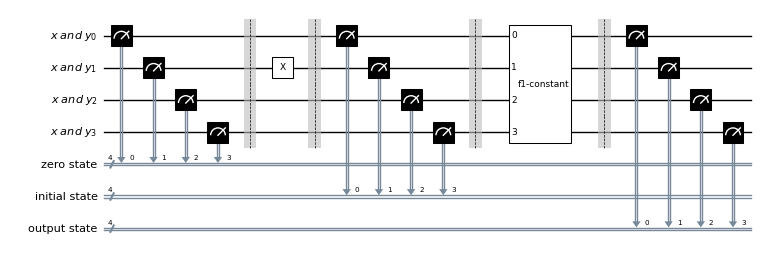

{'zero state: ': '0000', 'initial state: ': '0100', 'output state: ': '0100'}
bit representation: x1x2x3y1
x=b1b2b3= 0 0 0   {'zero state: ': '0000', 'initial state: ': '0000', 'output state: ': '0000'}
x=b1b2b3= 0 0 1   {'zero state: ': '0000', 'initial state: ': '0010', 'output state: ': '0010'}
x=b1b2b3= 0 1 0   {'zero state: ': '0000', 'initial state: ': '0100', 'output state: ': '0100'}
x=b1b2b3= 0 1 1   {'zero state: ': '0000', 'initial state: ': '0110', 'output state: ': '0110'}
x=b1b2b3= 1 0 0   {'zero state: ': '0000', 'initial state: ': '1000', 'output state: ': '1000'}
x=b1b2b3= 1 0 1   {'zero state: ': '0000', 'initial state: ': '1010', 'output state: ': '1010'}
x=b1b2b3= 1 1 0   {'zero state: ': '0000', 'initial state: ': '1100', 'output state: ': '1100'}
x=b1b2b3= 1 1 1   {'zero state: ': '0000', 'initial state: ': '1110', 'output state: ': '1110'}
--------------------------------------------------------------------------------
f2: Example state x=b1b2b3= 0 1 0


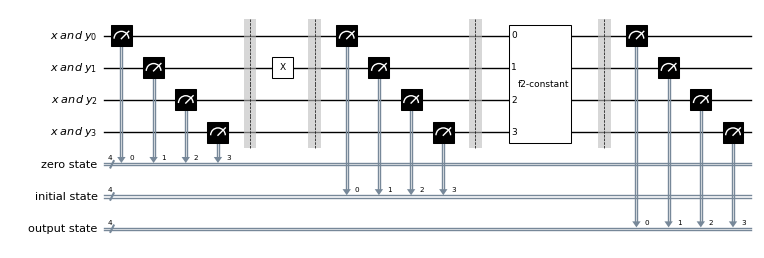

{'zero state: ': '0000', 'initial state: ': '0100', 'output state: ': '0101'}
bit representation: x1x2x3y1
x=b1b2b3= 0 0 0   {'zero state: ': '0000', 'initial state: ': '0000', 'output state: ': '0001'}
x=b1b2b3= 0 0 1   {'zero state: ': '0000', 'initial state: ': '0010', 'output state: ': '0011'}
x=b1b2b3= 0 1 0   {'zero state: ': '0000', 'initial state: ': '0100', 'output state: ': '0101'}
x=b1b2b3= 0 1 1   {'zero state: ': '0000', 'initial state: ': '0110', 'output state: ': '0111'}
x=b1b2b3= 1 0 0   {'zero state: ': '0000', 'initial state: ': '1000', 'output state: ': '1001'}
x=b1b2b3= 1 0 1   {'zero state: ': '0000', 'initial state: ': '1010', 'output state: ': '1011'}
x=b1b2b3= 1 1 0   {'zero state: ': '0000', 'initial state: ': '1100', 'output state: ': '1101'}
x=b1b2b3= 1 1 1   {'zero state: ': '0000', 'initial state: ': '1110', 'output state: ': '1111'}
--------------------------------------------------------------------------------
f3: Example state x=b1b2b3= 0 1 0


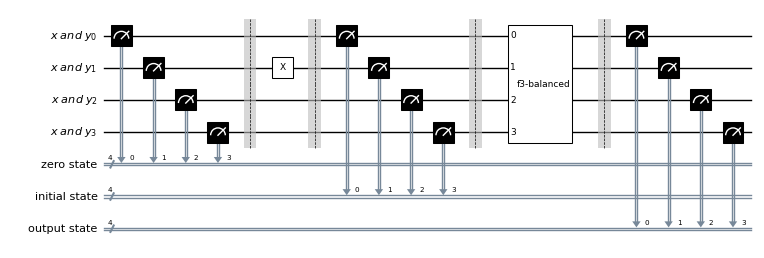

{'zero state: ': '0000', 'initial state: ': '0100', 'output state: ': '0101'}
bit representation: x1x2x3y1
x=b1b2b3= 0 0 0   {'zero state: ': '0000', 'initial state: ': '0000', 'output state: ': '0000'}
x=b1b2b3= 0 0 1   {'zero state: ': '0000', 'initial state: ': '0010', 'output state: ': '0010'}
x=b1b2b3= 0 1 0   {'zero state: ': '0000', 'initial state: ': '0100', 'output state: ': '0101'}
x=b1b2b3= 0 1 1   {'zero state: ': '0000', 'initial state: ': '0110', 'output state: ': '0111'}
x=b1b2b3= 1 0 0   {'zero state: ': '0000', 'initial state: ': '1000', 'output state: ': '1001'}
x=b1b2b3= 1 0 1   {'zero state: ': '0000', 'initial state: ': '1010', 'output state: ': '1011'}
x=b1b2b3= 1 1 0   {'zero state: ': '0000', 'initial state: ': '1100', 'output state: ': '1100'}
x=b1b2b3= 1 1 1   {'zero state: ': '0000', 'initial state: ': '1110', 'output state: ': '1110'}
--------------------------------------------------------------------------------
f4: Example state x=b1b2b3= 0 1 0


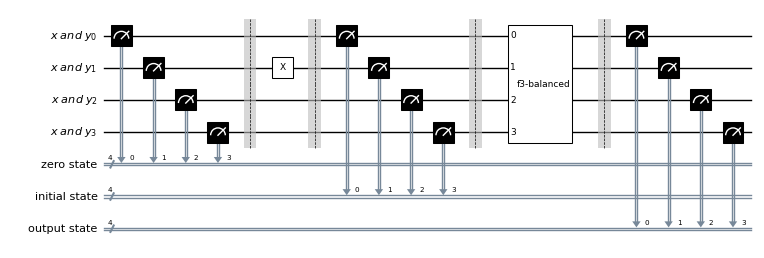

{'zero state: ': '0000', 'initial state: ': '0100', 'output state: ': '0100'}
bit representation: x1x2x3y1
x=b1b2b3= 0 0 0   {'zero state: ': '0000', 'initial state: ': '0000', 'output state: ': '0001'}
x=b1b2b3= 0 0 1   {'zero state: ': '0000', 'initial state: ': '0010', 'output state: ': '0011'}
x=b1b2b3= 0 1 0   {'zero state: ': '0000', 'initial state: ': '0100', 'output state: ': '0100'}
x=b1b2b3= 0 1 1   {'zero state: ': '0000', 'initial state: ': '0110', 'output state: ': '0110'}
x=b1b2b3= 1 0 0   {'zero state: ': '0000', 'initial state: ': '1000', 'output state: ': '1000'}
x=b1b2b3= 1 0 1   {'zero state: ': '0000', 'initial state: ': '1010', 'output state: ': '1010'}
x=b1b2b3= 1 1 0   {'zero state: ': '0000', 'initial state: ': '1100', 'output state: ': '1101'}
x=b1b2b3= 1 1 1   {'zero state: ': '0000', 'initial state: ': '1110', 'output state: ': '1111'}
--------------------------------------------------------------------------------


In [37]:
#bit 1 is the left most bit

print("Q1.2.b - Show each step of through circuit for different inputs")


def proof_of_work_2(circuit):
    bit1 = 0
    bit2 = 1
    bit3 = 0
    print("Example state x=b1b2b3=",  bit1, bit2, bit3)
    print(calc_answer(circuit, bit1, bit2, bit3, True, True))

    print("bit representation: x1x2x3y1")
    for i in range(2):
        for j in range(2):
            for k in range(2):
                print("x=b1b2b3=", i, j, k, end="   ")
                print(calc_answer(circuit, i, j, k, True))


print("f1: ", end="")
proof_of_work_2(f1())

print("--------------------------------------------------------------------------------")

print("f2: ", end="")
proof_of_work_2(f2())

print("--------------------------------------------------------------------------------")

print("f3: ", end="")
proof_of_work_2(f3())

print("--------------------------------------------------------------------------------")

print("f4: ", end="")
proof_of_work_2(f4())

print("--------------------------------------------------------------------------------")

### Q1.3

Without error the confidence is 80% </br>
With error the confidence is 69% </br>


Oracle


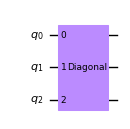

Diffuser


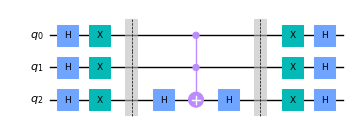

Grover


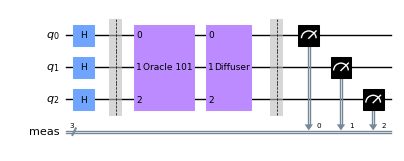

{'101': 80, '110': 6, '000': 2, '001': 1, '010': 4, '111': 3, '011': 3, '100': 1}


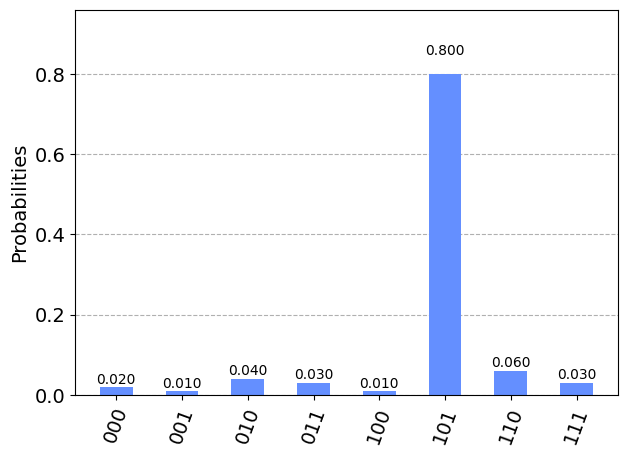

Oracle with error 


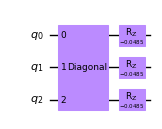

Diffuser with error


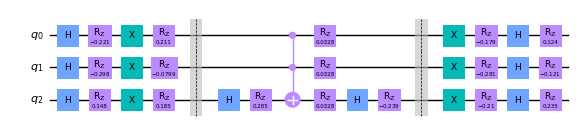

Grover with error


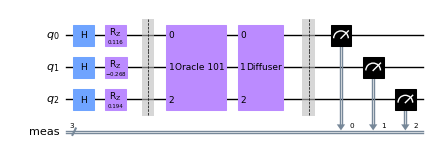

{'100': 7, '101': 69, '011': 5, '110': 3, '000': 4, '111': 6, '010': 4, '001': 2}


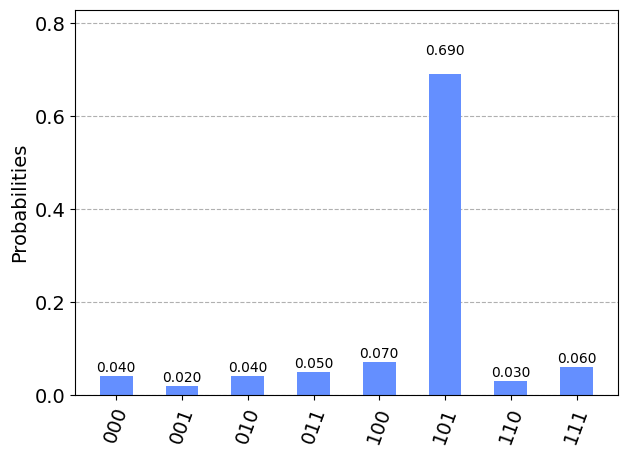

In [44]:

from qiskit.circuit.library import Diagonal
import random
from math import pi

error_level = 0 #pi * 0.1


def error(circuit, reg):
    global error_level
    if(error_level == 0):
        return
    err = (random.random()*2-1) * error_level
    circuit.rz(err, reg)


def oracle():
    oracle = Diagonal([1, 1, 1, 1, 1, -1, 1, 1])
    oracle.name = "Oracle 101"
    error(oracle, [0,1,2])
    return oracle


# created a general diffuser
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits, name="Diffuser")
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
        error(qc, qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
        error(qc, qubit)

    # Do multi-controlled-Z gate
    qc.barrier()
    qc.h(nqubits-1)
    error(qc, nqubits-1)

    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    error(qc, list(range(nqubits)))
    
    qc.h(nqubits-1)
    error(qc, nqubits-1)
    qc.barrier()
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
        error(qc, qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
        error(qc, qubit)

    return qc


def grov():
    n = 3
    diffu = diffuser(n).to_instruction()
    diffu.name = 'Diffuser'

    orc = oracle().to_instruction()

    grover_circuit = QuantumCircuit(n, name="Grover")

    for i in range(n):
        grover_circuit.h(i)
        error(grover_circuit, i)

    grover_circuit.barrier()
    grover_circuit.append(orc, [0,1,2])
    grover_circuit.append(diffu, [0,1,2])

    grover_circuit.measure_all()

    return grover_circuit




def run_grover():
    total_counts = {}
    for i in range(100):
        grover_circuit = grov()

        job = backend_sim.run(transpile(grover_circuit, backend_sim), shots=1)
        counts_1 = job.result().get_counts(grover_circuit)

        for key in counts_1:
            if key in total_counts:
                total_counts[key] += counts_1[key]
            else:
                total_counts[key] = counts_1[key]


    print(total_counts)
    display(plot_histogram(total_counts))


error_level = 0
print("Oracle")
display(oracle().draw('mpl', scale=0.5))
print("Diffuser")
display(diffuser(3).draw('mpl', scale=0.5))
print("Grover")
display(grov().draw('mpl', scale=0.5))
run_grover()


error_level = 0.1 * pi
print("Oracle with error ")
display(oracle().draw('mpl', scale=0.5))
print("Diffuser with error")
display(diffuser(3).draw('mpl', scale=0.5))
print("Grover with error")
display(grov().draw('mpl', scale=0.5))
run_grover()




## Q1.4

Big matrices seem to break scrolling in vscode, use scroll bar when scrolling through this section

### Defining Pauli Matrices

$I=\begin{bmatrix}
  1.00 &  0.00\\
  0.00 &  1.00
\end{bmatrix}$
$X=\begin{bmatrix}
  0.00 &  1.00\\
  1.00 &  0.00
\end{bmatrix}$
$Z=\begin{bmatrix}
  1.00 &  0.00\\
  0.00 & -1.00
\end{bmatrix}$

### Defining Logical Pauli Operators

$\overline{I} = I \otimes I \otimes I \otimes I $

$\overline{X_1} = X_1 X_3 = X \otimes I \otimes X \otimes I $

$\overline{Z_1} = Z_1 X_4 = Z \otimes I \otimes I \otimes Z $

$\overline{X_2} = X_2 X_3 = I \otimes X \otimes X \otimes I $

$\overline{Z_2} = Z_2 Z_4 = I \otimes Z \otimes I \otimes Z $

$\overline{Z_1 \otimes X_2} = Z \otimes X \otimes X \otimes Z  $

$\overline{X_1 \otimes Z_2} = X \otimes Z \otimes X \otimes Z  $


<br/>

### Logical CNOT gates

$CNOT_{1,2} = 0.5( I + Z_1 + X_2 - Z_1 \otimes X_2) $
\
$=> \overline{CNOT_{1,2}} = 0.5( \overline{I} + \overline{Z_1} + \overline{X_2} - \overline{Z_1 \otimes X_2}) $
\
$= \begin{bmatrix}
  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1 
\end{bmatrix}$


<br/>


$CNOT_{2,1} = 0.5( I + Z_2 + X_1 - X_1 \otimes Z_2) $
\
$=> \overline{CNOT_{2,1}} = 0.5( \overline{I} + \overline{Z_2} + \overline{X_1} - \overline{X_1 \otimes Z_2}) $
\
$=\begin{bmatrix}
  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0 \\
  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0 \\
  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0 \\
  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0 \\
  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1 
\end{bmatrix}$


### Define Logical Basis

$\ket{00}_L = \frac{1}{\sqrt{2}}(\ket{0000} + \ket{1111}) = \begin{bmatrix} 0.71 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.71 \end{bmatrix}^T$

$\ket{01}_L = \frac{1}{\sqrt{2}}(\ket{0110} + \ket{1001}) = \begin{bmatrix}
  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.71 &  0.00 &  0.00 &  0.71 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00
\end{bmatrix}^T$

$\ket{10}_L = \frac{1}{\sqrt{2}}(\ket{1010} + \ket{0101}) = \begin{bmatrix}
  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.71 &  0.00 &  0.00 &  0.00 &  0.00 &  0.71 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00
\end{bmatrix}^T$

$\ket{11}_L = \frac{1}{\sqrt{2}}(\ket{1100} + \ket{0011}) = \begin{bmatrix}
  0.00 &  0.00 &  0.00 &  0.71 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.71 &  0.00 &  0.00 &  0.00
\end{bmatrix}^T$

### Proof that CNOT1,2 is correct

$\overline{CNOT_{1,2}} \ket{00}_L = \begin{bmatrix}
  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1 
\end{bmatrix}\begin{bmatrix}
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71
\end{bmatrix}=\begin{bmatrix}
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71
\end{bmatrix} = \ket{00}_L
$





$\overline{CNOT_{1,2}} \ket{01}_L = \begin{bmatrix}
  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1 
\end{bmatrix}\begin{bmatrix}
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00
\end{bmatrix}=\begin{bmatrix}
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00
\end{bmatrix} = \ket{01}_L
$



$\overline{CNOT_{1,2}} \ket{10}_L = \begin{bmatrix}
  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1 
\end{bmatrix}\begin{bmatrix}
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00
\end{bmatrix}=\begin{bmatrix}
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00
\end{bmatrix} = \ket{11}_L
$



$\overline{CNOT_{1,2}} \ket{11}_L = \begin{bmatrix}
  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1 
\end{bmatrix}\begin{bmatrix}
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00
\end{bmatrix}=\begin{bmatrix}
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00
\end{bmatrix} = \ket{10}_L
$

### Proof that CNOT2,1 is correct

</br>

$\overline{CNOT_{2,1}} \ket{00}_L = \begin{bmatrix}
  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0 \\
  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0 \\
  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0 \\
  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0 \\
  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1 
\end{bmatrix}\begin{bmatrix}
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71
\end{bmatrix}=\begin{bmatrix}
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71
\end{bmatrix} = \ket{00}_L
$




$\overline{CNOT_{2,1}} \ket{01}_L = \begin{bmatrix}
  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0 \\
  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0 \\
  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0 \\
  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0 \\
  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1 
\end{bmatrix}\begin{bmatrix}
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00
\end{bmatrix}=\begin{bmatrix}
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00
\end{bmatrix} = \ket{11}_L
$



$\overline{CNOT_{2,1}} \ket{10}_L = \begin{bmatrix}
  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0 \\
  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0 \\
  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0 \\
  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0 \\
  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1 
\end{bmatrix}\begin{bmatrix}
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71
\end{bmatrix}=\begin{bmatrix}
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71
\end{bmatrix} = \ket{10}_L
$


$\overline{CNOT_{2,1}} \ket{11}_L = \begin{bmatrix}
  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0 \\
  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0 \\
  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0 \\
  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1  &  0  &  0 \\
  0  &  0  &  0  &  0  &  1  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0 \\
  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  0  &  1 
\end{bmatrix}\begin{bmatrix}
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00
\end{bmatrix}=\begin{bmatrix}
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.71\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00\\
  0.00
\end{bmatrix} = \ket{01}_L
$


Q2

In [46]:
#Q2a
import numpy as np
from sklearn import datasets
import scipy as sp
from math import pi

print("Q2.a")

iris = datasets.load_iris()

cov = np.cov(iris.data.T)

print("Covariance matrix is \n", cov)
print()

p = cov / np.trace(cov)

print("P is \n", p)
print()


e_i2piP = sp.linalg.expm( 1j * 2* pi * p )
print("e^i2piP is \n", e_i2piP)


(eig_values, eig_vectors) = np.linalg.eig(p)
print("eigen values for p is \n", eig_values)
print("eigen vectors for p is \n", eig_vectors)



Q2.a
Covariance matrix is 
 [[ 0.68569351 -0.042434    1.27431544  0.51627069]
 [-0.042434    0.18997942 -0.32965638 -0.12163937]
 [ 1.27431544 -0.32965638  3.11627785  1.2956094 ]
 [ 0.51627069 -0.12163937  1.2956094   0.58100626]]

P is 
 [[ 0.14994532 -0.00927934  0.27866333  0.11289647]
 [-0.00927934  0.04154411 -0.07208823 -0.02659972]
 [ 0.27866333 -0.07208823  0.68145793  0.28331983]
 [ 0.11289647 -0.02659972  0.28331983  0.12705264]]

e^i2piP is 
 [[ 0.95987297+0.12111623j -0.02097918+0.13021024j -0.02747432-0.18818283j
  -0.00981929-0.10156707j]
 [-0.02097918+0.13021024j  0.96773497+0.21291705j  0.01459751+0.00150838j
   0.00461572+0.02288817j]
 [-0.02747432-0.18818283j  0.01459751+0.00150838j  0.91739894-0.31674232j
  -0.03455543-0.14309588j]
 [-0.00981929-0.10156707j  0.00461572+0.02288817j -0.03455543-0.14309588j
   0.98353158-0.00613646j]]
eigen values for p is 
 [0.92461872 0.05306648 0.01710261 0.00521218]
eigen vectors for p is 
 [[ 0.36138659 -0.65658877 -0.58202985  0

Q2b


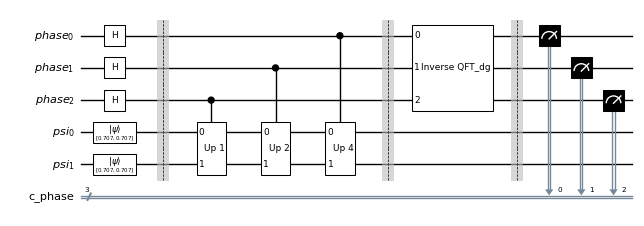

Iterations of circuit, breaks on 111
{'000': 1},{'100': 1},{'000': 1},{'100': 1},{'100': 1},{'100': 1},{'100': 1},{'000': 1},{'000': 1},{'000': 1},{'110': 1},{'100': 1},{'011': 1},{'000': 1},{'000': 1},{'100': 1},{'100': 1},{'110': 1},{'100': 1},{'000': 1},{'100': 1},{'100': 1},{'000': 1},{'100': 1},{'000': 1},{'100': 1},{'100': 1},{'100': 1},{'000': 1},{'011': 1},{'000': 1},{'000': 1},{'100': 1},{'110': 1},{'100': 1},{'000': 1},{'100': 1},{'100': 1},{'000': 1},{'110': 1},{'100': 1},{'010': 1},{'000': 1},{'100': 1},{'000': 1},{'111': 1},
psi 1:  [0.42948732-0.00375477j 0.02939854-0.06228126j 0.82449506+0.j
 0.36001568-0.03714728j]
fidelity:  0.9880812676468992


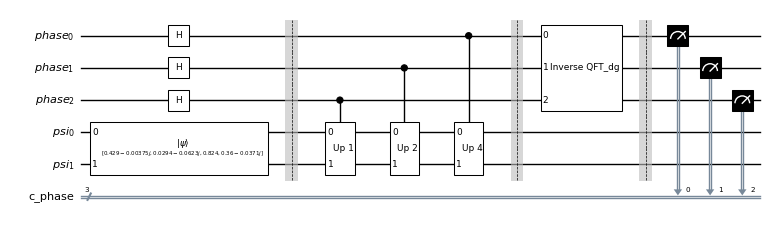

Iterations of circuit, breaks on 111
{'100': 1},{'110': 1},{'100': 1},{'100': 1},{'110': 1},{'100': 1},{'100': 1},{'100': 1},{'000': 1},{'000': 1},{'100': 1},{'000': 1},{'000': 1},{'100': 1},{'000': 1},{'110': 1},{'110': 1},{'110': 1},{'100': 1},{'100': 1},{'100': 1},{'100': 1},{'000': 1},{'110': 1},{'100': 1},{'100': 1},{'110': 1},{'110': 1},{'010': 1},{'110': 1},{'100': 1},{'000': 1},{'100': 1},{'000': 1},{'100': 1},{'110': 1},{'110': 1},{'110': 1},{'000': 1},{'100': 1},{'000': 1},{'100': 1},{'100': 1},{'100': 1},{'100': 1},{'100': 1},{'110': 1},{'110': 1},{'000': 1},{'100': 1},{'000': 1},{'100': 1},{'100': 1},{'000': 1},{'110': 1},{'000': 1},{'110': 1},{'100': 1},{'100': 1},{'011': 1},{'111': 1},
psi 2:  [0.42948732-0.00375477j 0.02939854-0.06228126j 0.82449506+0.j
 0.36001568-0.03714728j]
fidelity:  0.9996048263038522


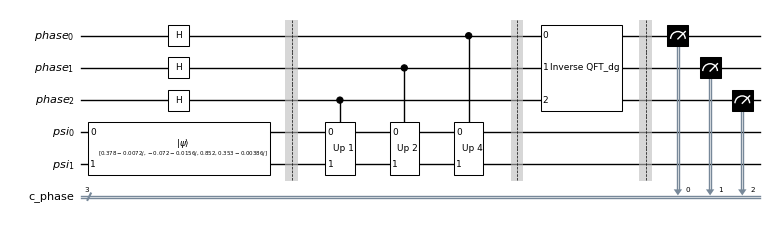

Iterations of circuit, breaks on 111
{'000': 1},{'100': 1},{'000': 1},{'011': 1},{'110': 1},{'000': 1},{'110': 1},{'000': 1},{'100': 1},{'110': 1},{'000': 1},{'000': 1},{'110': 1},{'100': 1},{'100': 1},{'000': 1},{'100': 1},{'100': 1},{'100': 1},{'100': 1},{'100': 1},{'110': 1},{'100': 1},{'111': 1},
psi 3:  [0.42948732-0.00375477j 0.02939854-0.06228126j 0.82449506+0.j
 0.36001568-0.03714728j]
fidelity:  0.9999867715051299


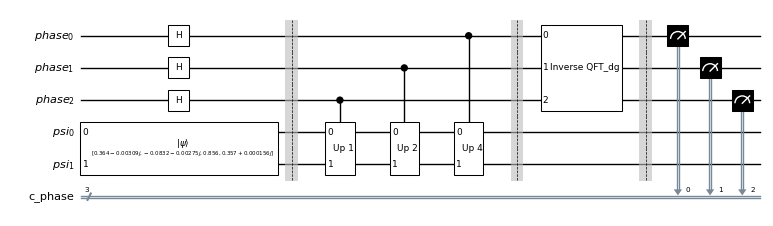

Iterations of circuit, breaks on 111
{'110': 1},{'110': 1},{'100': 1},{'110': 1},{'100': 1},{'100': 1},{'100': 1},{'100': 1},{'110': 1},{'000': 1},{'110': 1},{'110': 1},{'100': 1},{'000': 1},{'110': 1},{'100': 1},{'000': 1},{'100': 1},{'100': 1},{'100': 1},{'100': 1},{'110': 1},{'111': 1},
psi 4:  [0.42948732-0.00375477j 0.02939854-0.06228126j 0.82449506+0.j
 0.36001568-0.03714728j]
fidelity:  0.9999995504076648
Principle Eigen Vector:
[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
Principle Eigen Vector phi 4:
[ 0.36159978-7.59764569e-04j -0.08435239-5.20256518e-04j
  0.85661762+0.00000000e+00j  0.35823969+9.86885851e-05j]
Principle Eigen Vector phi 4 absolute:
[0.36160058 0.08435399 0.85661762 0.3582397 ]


In [52]:
#Q2b
import numpy as np
from sklearn import datasets
import scipy as sp
from math import pi, sqrt

from qiskit.circuit.library import QFT
from qiskit.extensions import UnitaryGate

print("Q2b")


def qpe_c(psi_in, num_phase_bits=3):
    phase_quibts = QuantumRegister(num_phase_bits, "phase")
    psi = QuantumRegister(2, "psi")
    phase_bits = ClassicalRegister(num_phase_bits, "c_phase")

    qpe_circuit = QuantumCircuit(phase_quibts, psi, phase_bits, name="QPE")
    
    qpe_circuit.h(phase_quibts)
    if(len(psi_in)==2):
        qpe_circuit.initialize(psi_in[0], num_phase_bits)
        qpe_circuit.initialize(psi_in[1], num_phase_bits+1)
    else:
        qpe_circuit.initialize(psi_in, psi)
    

    qpe_circuit.barrier()

    for i in range(num_phase_bits):
        label = "Up " + str(2**i)
        u = UnitaryGate(sp.linalg.expm( 1j * 2* pi * 2**i * p), label=label).control(1)
        qpe_circuit.append(u, [num_phase_bits - i - 1 ,num_phase_bits,num_phase_bits+1])
  
    qpe_circuit.barrier()


    qpe_circuit.append(QFT(num_phase_bits, name="Inverse QFT").inverse(), phase_quibts)

    qpe_circuit.barrier()

    qpe_circuit.measure(phase_quibts, phase_bits)

    return qpe_circuit




def psi_out_111(qpe):
    print("Iterations of circuit, breaks on 111")
    while True:
        job = backend_sv.run(transpile(qpe, backend_sv), shots=1)
        result = job.result()
        counts = result.get_counts(qpe)
        print(counts, end=",")
        if('111' in counts):
            print()
            state = partial_trace(result.get_statevector(), [0,1,2]) # snapshot in qiskit keeps all the qubits, need to trace out the measured ones
            return state.to_statevector().data


psi_0 = [[1/sqrt(2), 1/sqrt(2)], [1/sqrt(2), 1/sqrt(2)]]
    
def fidelity(a,b):
    print("fidelity: ", np.absolute(a.dot(b)))

principle_eigen_vector = eig_vectors.T[0]


qpe = qpe_c(psi_0)
display(qpe.draw('mpl',style="bw", scale = 0.5))
psi_1 = psi_out_111(qpe)
print("psi 1: ", psi_1)
fidelity(psi_1, principle_eigen_vector)


qpe = qpe_c(psi_1)
display(qpe.draw('mpl',style="bw", scale = 0.5))
psi_2 = psi_out_111(qpe)
print("psi 2: ", psi_1)
fidelity(psi_2, principle_eigen_vector)


qpe = qpe_c(psi_2)
display(qpe.draw('mpl',style="bw", scale = 0.5))
psi_3 = psi_out_111(qpe)
print("psi 3: ", psi_1)
fidelity(psi_3, principle_eigen_vector)

qpe = qpe_c(psi_3)
display(qpe.draw('mpl',style="bw", scale = 0.5))
psi_4 = psi_out_111(qpe)
print("psi 4: ", psi_1)
fidelity(psi_4, principle_eigen_vector)

print("Principle Eigen Vector:")
print(principle_eigen_vector)
print("Principle Eigen Vector phi 4:")
print(psi_4)

print("Principle Eigen Vector phi 4 absolute:")
print(np.absolute(psi_4))



Q2c
Example diagram for first principle eigen vector


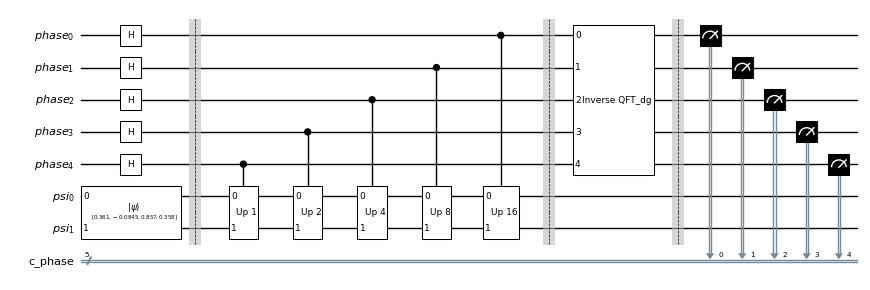

First Principle Eigen Vector 1: [ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
First Principle Eigen Value 1: 0.9246187232017269
b1,b2,b3,b4,b5:  00101
Measurement Outcome:  0.15625
Estimated Eigen Value:  0.078125

Second Principle Eigen Vector 2: [-0.65658877 -0.73016143  0.17337266  0.07548102]
Second Principle Eigen Value 2: 0.0530664831170677
b1,b2,b3,b4,b5:  00011
Measurement Outcome:  0.09375
Estimated Eigen Value:  0.046875


In [145]:
#Q2c
def psi_values_out(qpe):
    job = backend_sv.run(transpile(qpe, backend_sv), shots=2048)
    result = job.result()
    counts = result.get_counts(qpe)
    highest = -1
    highestCount = None
    for count in counts:    
        if(counts[count] > highest):
            highest = counts[count]
            highestCount = count

    measurement_outcome = 0
    highestCount = highestCount[::-1]
    for i in range(len(highestCount)):
        if(highestCount[i]=='1'):
            measurement_outcome += 1/(2**(i+1))

    print("b1,b2,b3,b4,b5: ", highestCount)
    print("Measurement Outcome: ", measurement_outcome)
    eigen_value_est = int(highestCount, 2)/2**(len(highestCount)+1)
    print("Estimated Eigen Value: ", eigen_value_est)

print("Q2c")



principle_eigen_vector1 = eig_vectors.T[0]
principle_eigen_vector2 = eig_vectors.T[1]


qpe = qpe_c(principle_eigen_vector1, 5)
print("Example diagram for first principle eigen vector")
display(qpe.draw('mpl',style="bw", scale = 0.5))
print("First Principle Eigen Vector 1:", principle_eigen_vector1)
print("First Principle Eigen Value 1:", eig_values[0])
psi_values_out(qpe)

qpe = qpe_c(principle_eigen_vector2, 5)
print()
print("Second Principle Eigen Vector 2:", principle_eigen_vector2)
print("Second Principle Eigen Value 2:", eig_values[1])
psi_values_out(qpe)



# Q3

### Q3.a

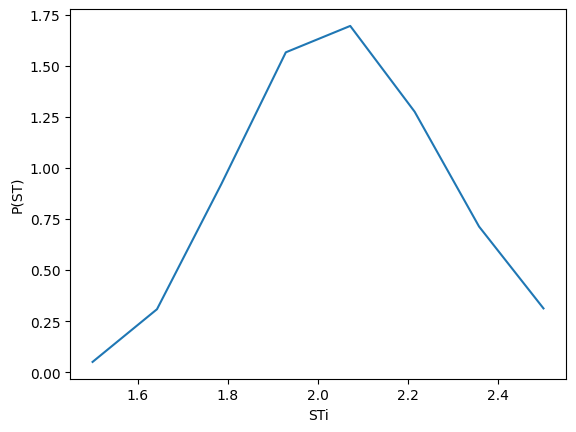

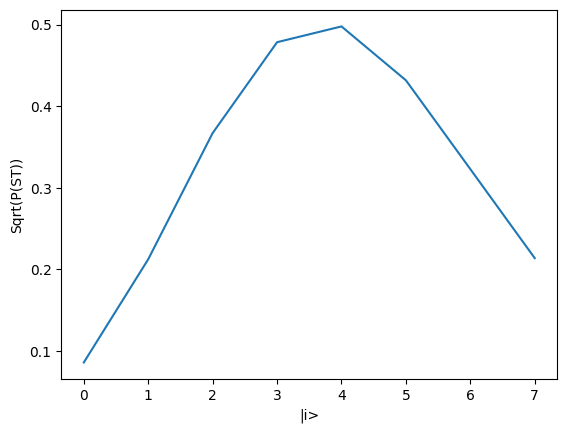

In [121]:
from math import sqrt, pi, exp, log as ln
import numpy as np
import matplotlib.pyplot as plt

def P(St):
    sig = 0.125
    T=300/365
    r=0.04
    S0=2

    sig2 = sig**2

    coef = 1/(St * sig * sqrt(2*pi*T)) 
    numerator = ln(St) - ln(S0) - T * (r - sig2/2)
    denomenator = 2 * sig2 * T

    exp_coef = -(numerator**2)/denomenator
    return coef * exp(exp_coef)



St_min = 1.5
St_max = 2.5
num_points = 8
step = (St_max - St_min)/(num_points-1)

P_Sti = []
Sti = []

for i in range(0,8):
    x = i * step + St_min
    p = P(x)
    P_Sti.append(p)
    Sti.append(x)

def sqrt_amp(a):
    sumP = 0
    for ai in a:
        sumP += ai

    ret = []
    for ai in a:
        ret.append(sqrt(ai/sumP))
    
    return ret


amp_P_Sti = sqrt_amp(P_Sti)


plt.plot(Sti,P_Sti)
plt.ylabel('P(ST)')
plt.xlabel('STi')
plt.show()

plt.plot(np.arange(0, 8),amp_P_Sti)
plt.ylabel('Sqrt(P(ST))')
plt.xlabel('|i>')
plt.show()




### Q3.b

In [135]:
import pennylane as qml
from pennylane import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 100

dev = qml.device("default.qubit", wires=3) 



def statepreparation(a):
    qml.RY(a[0], wires=0)
    qml.RX(a[1], wires=0)
    qml.RY(a[2], wires=1)
    qml.RX(a[3], wires=1)
    qml.RY(a[4], wires=2)
    qml.RX(a[5], wires=2)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])

@qml.qnode(dev)
def circuit(angless):
    for angles in angless:
        statepreparation(angles)
    return qml.probs(wires=[0, 1, 2])

def cost_function(sqr_pi_theta_n, sqr_p_st_n):
    sum = 0
    for (sqr_pi_theta_i, sqr_p_st_i) in zip(sqr_pi_theta_n, sqr_p_st_n):
        sum += sqr_pi_theta_i * sqr_p_st_i
    return np.abs(1-sum)




print(qml.draw(circuit)([[0,0,0,0,0,0,0,0]]))


0: ──RY(0.00)──RX(0.00)─╭●─╭●─┤ ╭Probs
1: ──RY(0.00)──RX(0.00)─╰X─│──┤ ├Probs
2: ──RY(0.00)──RX(0.00)────╰X─┤ ╰Probs


Model with  1  layers
0: ──RY(1.62)───RX(-0.61)─╭●─╭●─┤ ╭Probs
1: ──RY(-0.53)──RX(-1.07)─╰X─│──┤ ├Probs
2: ──RY(0.87)───RX(-2.30)────╰X─┤ ╰Probs
Iter:     1 | Cost: 0.1540857 | Fidelity: 0.7164360 
Iter:    51 | Cost: 0.0401269 | Fidelity: 0.9215522 
Iter:   101 | Cost: 0.0118848 | Fidelity: 0.9764046 
Iter:   151 | Cost: 0.0076002 | Fidelity: 0.9848615 
Iter:   201 | Cost: 0.0070550 | Fidelity: 0.9859403 
Iter:   251 | Cost: 0.0069685 | Fidelity: 0.9861118 
Iter:   301 | Cost: 0.0069489 | Fidelity: 0.9861506 
Iter:   351 | Cost: 0.0069434 | Fidelity: 0.9861614 
Iter:   401 | Cost: 0.0069417 | Fidelity: 0.9861647 
Iter:   451 | Cost: 0.0069412 | Fidelity: 0.9861658 
Final | Cost: 0.0069410 | Fidelity: 0.9861658 


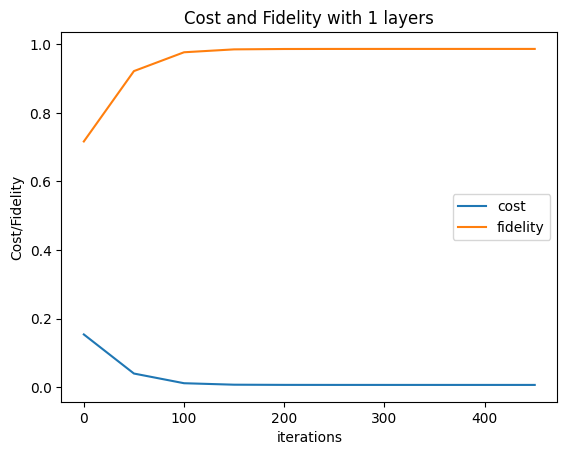

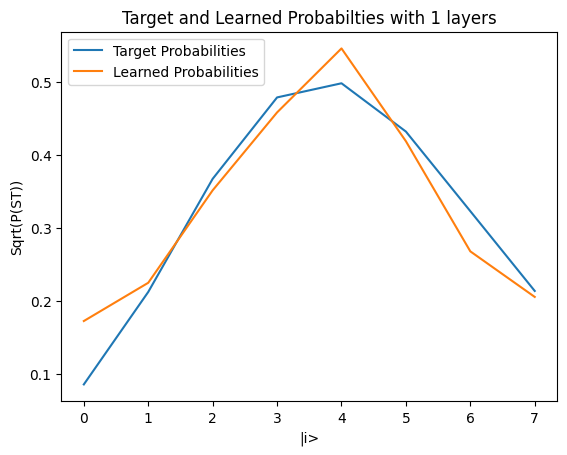

Model with  2  layers
0: ──RY(1.62)───RX(-0.61)─╭●─╭●──RY(1.74)──RX(-0.76)─╭●─╭●─┤ ╭Probs
1: ──RY(-0.53)──RX(-1.07)─╰X─│───RY(0.32)──RX(-0.25)─╰X─│──┤ ├Probs
2: ──RY(0.87)───RX(-2.30)────╰X──RY(1.46)──RX(-2.06)────╰X─┤ ╰Probs
Iter:     1 | Cost: 0.2199913 | Fidelity: 0.6092773 
Iter:    51 | Cost: 0.0990417 | Fidelity: 0.8119250 
Iter:   101 | Cost: 0.0506057 | Fidelity: 0.9015060 
Iter:   151 | Cost: 0.0184245 | Fidelity: 0.9635654 
Iter:   201 | Cost: 0.0064901 | Fidelity: 0.9870819 
Iter:   251 | Cost: 0.0033429 | Fidelity: 0.9933313 
Iter:   301 | Cost: 0.0022579 | Fidelity: 0.9954922 
Iter:   351 | Cost: 0.0016486 | Fidelity: 0.9967074 
Iter:   401 | Cost: 0.0012392 | Fidelity: 0.9975245 
Iter:   451 | Cost: 0.0009591 | Fidelity: 0.9980835 
Final | Cost: 0.0007693 | Fidelity: 0.9980835 


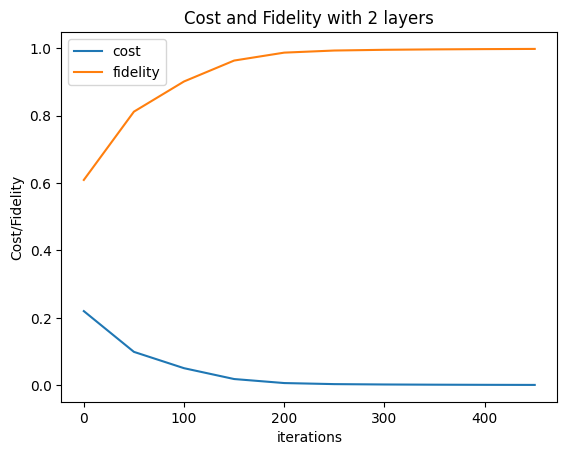

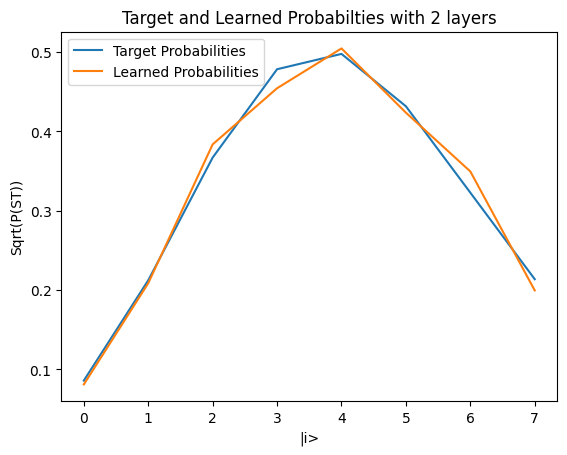

In [147]:
def train_model(layers):
    print("Model with ", layers, " layers")
    np.random.seed(1)
    var = 1 * np.random.randn(layers, 6)
    print(qml.draw(circuit)(var))


    opt = qml.NesterovMomentumOptimizer(0.01)

    def cross_entropy(y, p):
        y = np.array(y)
        p = np.array(p)
        loss_array = -y*np.log(p)
        loss_array = np.sum(loss_array, axis=-1)
        return np.mean(loss_array)
        
    def cost(angles):
        aprox_probs = np.sqrt(circuit(angles))
        return cost_function(aprox_probs,amp_P_Sti)

    def fidelity(a,b):
        return np.dot(a,b)*np.dot(b,a)


    costs = []
    fidelities = []

    for it in range(500):
     
        var, cost_value = opt.step_and_cost(cost, var)
        if(it % 50 == 0):
            aprox_probs = np.sqrt(np.array(circuit(var)))
            fidelity_value = fidelity(aprox_probs, amp_P_Sti)
            
            costs.append(cost_value)
            fidelities.append(fidelity_value)

            print("Iter: {:5d} | Cost: {:0.7f} | Fidelity: {:0.7f} "
                "".format(it + 1, cost_value, fidelity_value))
           

    print("Final | Cost: {:0.7f} | Fidelity: {:0.7f} "
        "".format(cost_value, fidelity_value))
    
    
    iterations = np.arange(0, 500, 50)
    plt.title("Cost and Fidelity with " + str(layers) + " layers")
    plt.plot(iterations, costs, label="cost")
    plt.plot(iterations, fidelities, label="fidelity")
    plt.ylabel('Cost/Fidelity')
    plt.xlabel('iterations')
    plt.legend()
    plt.show()

    plt.title("Target and Learned Probabilties with " + str(layers) + " layers")
    plt.plot(np.arange(0, 8),amp_P_Sti, label="Target Probabilities")
    plt.plot(np.arange(0, 8),aprox_probs, label="Learned Probabilities")
    plt.ylabel('Sqrt(P(ST))')
    plt.xlabel('|i>')
    plt.legend()
    plt.show()

train_model(1)
train_model(2)